In [2]:
# Load some needed packages
library(grid)
library(gridExtra)
library(ggplot2)
library(dplyr)
library(repr)
library(RColorBrewer)
library(reshape2)
library(tidyr)
library(Hmisc)


Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths

Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    combine, src, summarize

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units



In [3]:
# CMI-Based Color Scheme
cmi_main_blue="#0071b2"
cmi_grey="#929d9e"
cmi_light_blue="#00c4d9"
cmi_pea_green="#b5bf00"

cmi_rich_green="#73933d"
cmi_rich_purple="#8e7fac"
cmi_rich_red="#d75920"
cmi_rich_blue="#4c87a1"
cmi_rich_aqua="#66c7c3"
cmi_rich_orange="#eebf42"

cmi_vibrant_yellow="#ffd457"
cmi_vibrant_orange="#f58025"
cmi_vibrant_green="#78a22f"
cmi_vibrant_garnet="#e6006f"
cmi_vibrant_purple="#9A4d9e"
cmi_vibrant_blue="#19398a"

cmi_site_colors = c(cmi_vibrant_blue,
                    cmi_rich_blue,
                    cmi_vibrant_purple,
                    cmi_vibrant_garnet,
                    cmi_rich_red,
                    cmi_vibrant_orange,
                    cmi_vibrant_yellow,
                    cmi_vibrant_green)
cmi_site_colors_ramp = colorRampPalette(cmi_site_colors)

## Plotting functions

In [4]:
###
# FUNCTIONS - TO FILTER DATA
###

remove_nas <- function(df, measure) {
    na_inds <- is.na(df[[measure]])
    cat(sprintf("...removing %i points with NA values\n", sum(na_inds)))
    df      <- df[!na_inds,]
    return(df)
}

get_outlier_inds <- function(dat, times.iqr=3) {
    # We figure out the lower and upper limit of acceptable data
    # similar to the approach taken with Tukey box plots
    upper.limit <- quantile(dat, 0.75) + times.iqr*IQR(dat)
    lower.limit <- quantile(dat, 0.25) - times.iqr*IQR(dat)
    # and remove the rows that are outside this bound
    inds    <- (dat > upper.limit) | (dat < lower.limit)
    return(inds)
}

# Sometimes extreme data-points can skew the plot 
# and make it difficult to see the spread of the data.
# If requested, we can remove these points
# Note: this only removes outliers for a given measure
remove_outliers <- function(df, measure, times.iqr=3) {
    dat     <- df[[measure]]    
    inds    <- get_outlier_inds(dat, times.iqr)
    df      <- df[!inds,]
    cat(sprintf("...removed %i outlier points\n", sum(inds)))
    
    return(df)
}


###
# FUNCTIONS - RELATED TO PERCENTILES
###


# In preperation for plotting the percentile lines
# we calculate the percentiles in advance
# and have some code to do the plotting for later
# We will be looking at 1%, 5%, 25%, 50%, 75%, 95%, & 99%
calc_percentiles <- function(df, measure) {
    # In our plots, we want to have percentile lines to indicate the 
    # distribution of each site relative to the whole sample
    qvals       <- c(0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99)
    qcat        <- c(1,5,25,50,25,5,1)
    qline       <- c(3, 2, 5, 1, 5, 2, 3)
    qsize       <- c(.4, .25, .3, .25, .3, .25, .4)
    qcols       <- c("grey10", "grey10", "grey10", "grey50", "grey10", "grey10", "grey10")
    
    # Get the percentiles
    percentiles <- quantile(df[[measure]], qvals, na.rm=T)
    
    # Merge with name (qcat), line type (qline), and line width (qsize)
    # There's a weird error if I include qcols so won't do that here
    percentiles_df          <- as.data.frame(cbind(percentiles, qcat, qline, qsize))
    percentiles_df$qline    <- as.factor(qline)
    percentiles_df$qcat     <- as.factor(qcat)
    attr(percentiles_df, "qcols") <- qcols
    
    return(percentiles_df)
}

# This function will add percentile lines in the background
# plot: ggplot object
# pdf: percentile data frame
compile_percentiles <- function(pdf, measure) {
  cols <- attr(pdf, "qcols")
  ret <- lapply(1:nrow(pdf), function(i) {
    p <- pdf[i,]
    if (!is.null(cols)) {
      plot <- geom_hline(aes(yintercept=percentiles), data=p, 
                         size=as.numeric(p$qsize), linetype=as.numeric(p$qline), 
                         color=cols[i])
      #as.character(p$qcolor[1])
    } else {
      plot <- geom_hline(aes(yintercept=percentiles), data=p, 
                         size=as.numeric(p$qsize[1]), linetype=as.numeric(p$qline[1]), 
                         color="grey50")
    }
    return(plot)
  })
  return(ret)
}


###
# FUNCTIONS - TO DO THE PLOTTING
###


# Now we finally have one function that does the plotting bit
# It will also call the percentile functions above
# Also assume a site column and a global (all site) column
plot_measure <- function(df, measure, desc, site.col="site.name", plot=TRUE, 
                         outfile=NULL, rm.outlier=FALSE) 
{
    cat("Plotting measure", measure, "-", desc, "\n")
    
    # 1. Remove any missing (NA) values
    df <- remove_nas(df, measure)
    
    # 2. Remove outliers > 3xIQR
    if (rm.outlier) df <- remove_outliers(df, measure)
    
    # Add global column if needed
    if (!("global" %in% colnames(df))) {
      df$global <- "All Sites"
    }
 
    # 3. Start plot
    pg1=ggplot(df, aes_string(x=site.col, y=measure))
    
    # 4. Add the percentile lines (1%, 5%, 25%, 50%, 75%, 95%, 99%)
    perc_df <- calc_percentiles(df, measure)
    pg2=pg1 + compile_percentiles(perc_df, measure)  
  
    # 5. Add main plot
    # - violin plot + boxplot for all the data
    # - jitter plot for each site (adjust the color)
    # - x and y labels
    nsites <- length(unique(df[[site.col]]))
    pg3=pg2 + 
      geom_violin(aes(x=global), color="gray50") + 
      geom_boxplot(aes(x=global), width=.1, fill="gray50", outlier.size=0) + 
      geom_jitter(aes_string(color=site.col), position = position_jitter(width = .1), size=0.5) + 
      scale_color_manual(values=c(brewer.pal(4,"Dark2"), cmi_site_colors_ramp(nsites))) + 
      ylab(desc) +
      xlab("") 
    
    # 6. Setup text, margins, etc
    pg4=pg3 +
      theme_bw() + 
      theme(panel.grid.major.x= element_blank(),
            panel.grid.minor.x= element_blank(),
            panel.grid.major.y= element_blank(),
            panel.grid.minor.y= element_blank(),
            plot.title = element_text(family = "ArialMT",
                                      face = "plain",
                                      size = 10,
                                      vjust = 0,
                                      hjust = 0.5),
            axis.text.x = element_text(family = "ArialMT",
                                       face = "plain",
                                       size = 8, 
                                       angle = 45, 
                                       hjust = 1.0),
            axis.text.y = element_text(family = "ArialMT", 
                                       face = "plain", 
                                       size = 8, 
                                       angle = 90, 
                                       hjust = 0.5),
            axis.title.y = element_text(family = "ArialMT", 
                                        face = "plain", 
                                        size = 10, 
                                        angle = 90, 
                                        vjust = 0.9),
            axis.ticks.length = unit(.15, "lines"),
            plot.margin = unit(c(.25, .25, 0.25, .25), 
                               "lines"),
            legend.position   = "none")
        
    # End
    pg=pg4
    
    # 7. Plot
    if (plot) {
        cat("...plotting\n")
        print(pg)
    }
    
    # 8. Save
    if (!is.null(outfile)) {
        cat("...saving to", outfile, "\n")
        ggsave(outfile, pg, height=3, width=6, dpi=100)
    }
    
    return(pg)
}

In [5]:
# QC hand ratings
qc_qa_plots<-function(df,qc_var,label_strings, pdf_fname, fig_size_w, fig_size_h, ncol, nrow){
    
    pdf(pdf_fname, width = fig_size_w, height = fig_size_h, family="ArialMT")
    
    grid.newpage()

    pushViewport(viewport(layout = grid.layout(nrow, ncol)))
    
    mean_sdlow<-function(x) (mean(x)-sd(x))
        
    mean_sdhigh<-function(x) (mean(x)+sd(x))
    
    vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)

    pval_thresh=c(0.05,0.01,0.001,0.0001)
    pval_indicators=c("*","**","***","****")
        
    measure.vars = unique(df$Measure)

    for (i in seq(1,length(measure.vars)))
    {
        # get only the rows corresponding to this measure
        sdf<- df %>% filter(Measure == measure.vars[i])
        sdf_ranges <- sdf %>% 
                       group_by_(as.formula(sprintf('%s ~ .',qc_var))) %>% 
                         summarise(y=mean(value),y.max=mean_sdhigh(value),y.min=mean_sdlow(value)) %>% 
                             ungroup
        
        val_range=quantile(sdf$value, probs = c(0.02,.98))
        val_range["2%"]=min(val_range["2%"],min(sdf_ranges$y.min))
        val_range["98%"]=max(val_range["98%"],max(sdf_ranges$y.max))

        
        formula=sprintf("value ~ as.factor(%s)",qc_var)
        # get the lable and annotate to indicate statistical significance of the difference
        pval<-wilcox.test(as.formula(formula),data=sdf)$p.value

        pval_string="ns"
        for (t in seq(1,length(pval_thresh)))
        {
            if(pval < pval_thresh[t])
            {
                pval_string=pval_indicators[t]
            }
        }

        print(paste(measure.vars[i],label_strings[[measure.vars[i]]],pval_string,sprintf('pval %e',pval)))
        
        x_string=sprintf("as.factor(%s)",qc_var)
        p <- ggplot(sdf, aes_string(x=x_string, y='value', fill=x_string)) + 
            geom_boxplot(outlier.shape = NA, width=.5, fill='white') + 
            geom_point(data=sdf_ranges,aes_string(x=x_string,y='y'),color="red",fill="red",size=1)+
            geom_point(data=sdf_ranges,aes_string(x=x_string,y='y.max'),shape=24,color="red",fill="red",size=1)+
            geom_point(data=sdf_ranges,aes_string(x=x_string,y='y.min'),shape=25,color="red",fill="red",size=1)+
            theme_bw() +
            ggtitle(pval_string)+
            xlab("")+
            ylab(label_strings[[measure.vars[i]]])+
            theme(legend.position = "none",
                  plot.title = element_text(family = "ArialMT",
                                             face = "plain",
                                             size = 10,
                                             vjust = 0,
                                             hjust = 0.5),
                  axis.text.x = element_text(family = "ArialMT",
                                             face = "plain",
                                             size = 8, 
                                             angle = 0, 
                                             hjust = 0.5),
                  axis.text.y = element_text(family = "ArialMT", 
                                             face = "plain", 
                                             size = 8, 
                                             angle = 90, 
                                             hjust = 0.5),
                  axis.title.y = element_text(family = "ArialMT", 
                                              face = "plain", 
                                              size = 10, 
                                              angle = 90, 
                                              vjust = 0.9),
                  plot.margin = unit(c(.25, .25, 0.25, .25), 
                                     "lines")) +

            # reduce the range to between the 2% and 98% quartiles to make the plot
            # range more readible, do this without censoring so that the bars will go
            # out of frame     
            coord_cartesian(ylim=with(sdf, val_range))


        # get the location of this plot in the grid
        x=ceiling(i/ncol)
        y=((i-1) %% ncol)+1

        # add the plot to the grid
        print(p, vp = vplayout(x, y))
    }
    dev.off()
}

# Read in and tidy the manual QC ratings

## Lets get the pheno file directly from the Internets!

In [6]:
pheno_df<-read.csv("http://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE/Phenotypic_V1_0b_preprocessed1.csv")

### Conform the names of the raters and their ratings


In [7]:
#conform the names of the raters and their ratings
rater_cols <- setdiff(grep("*rater_", names(pheno_df)),grep("*notes_rater", names(pheno_df)))

# reduce to the columns of interest
pheno_df=pheno_df[c("SUB_ID","SITE_ID",names(pheno_df)[rater_cols],"SUB_IN_SMP")]

# rename SUB_IN_SMP to rater #4
names(pheno_df)[1]="Participant"
names(pheno_df)[8]="qc_rater_4"

# lets be really conservative and make all "maybe" fail
pheno_df[pheno_df=="maybe"]<-"fail"

# rater 4 used 0s and 1s instead of OK and fail, rename them
pheno_df$qc_rater_4=factor(pheno_df$qc_rater_4,levels=c(0,1),labels=c("fail","OK"))

# lets code all missing values as NA, so that they can be easily ignored in future processing
pheno_df[pheno_df==""]<-NA

head(pheno_df)

,Participant,SITE_ID,qc_rater_1,qc_anat_rater_2,qc_func_rater_2,qc_anat_rater_3,qc_func_rater_3,qc_rater_4
1,50002,PITT,fail,OK,fail,OK,fail,OK
2,50003,PITT,OK,OK,OK,OK,OK,OK
3,50004,PITT,OK,OK,OK,OK,OK,OK
4,50005,PITT,OK,OK,fail,OK,OK,fail
5,50006,PITT,OK,OK,fail,OK,OK,OK
6,50007,PITT,OK,OK,fail,OK,OK,OK


### Calculate consensus ratings for the anatomical data

In [8]:
pheno_df$qc_anat<-apply(pheno_df[,c(3,4,6,8)],1, function(x) sum(x=="OK", na.rm=T))
pheno_df$qc_anat<-(pheno_df$qc_anat > 2) + 1
pheno_df$qc_anat<-factor(pheno_df$qc_anat, levels=c(1,2), labels=c("Fail", "OK"))

### Calculate consensus ratings for the functional data

In [9]:
pheno_df$qc_func<-apply(pheno_df[,c(3,5,7,8)],1, function(x) sum(x=="OK", na.rm=T))
pheno_df$qc_func<-(pheno_df$qc_func > 2) + 1
pheno_df$qc_func<-factor(pheno_df$qc_func, levels=c(1,2), labels=c("Fail", "OK"))

In [13]:
pheno_df %>% group_by(qc_func,qc_anat) %>% summarise(N=n())

,qc_func,qc_anat,N
1,Fail,Fail,95
2,Fail,OK,110
3,OK,Fail,83
4,OK,OK,824


# ABIDE Anatomical QAP measures

### Read in the QAP measures, reduce to only the columns of interest and format for later processing

In [236]:
abide_anat_spat_df<-read.csv("2016_05_ABIDE_qap_anatomical_spatial.csv")

abide_anat_spat_df=merge(abide_anat_spat_df, pheno_df[c('Participant','qc_anat')], by='Participant')

id.vars=c('Participant','Site','Session','Series','qc_anat')
measure.vars=c('CNR','Cortical.Contrast','EFC','FBER','FWHM','Qi1','SNR')
abide_anat_spat_df<-abide_anat_spat_df[c(id.vars,measure.vars)]

abide_anat_spat_df=melt(abide_anat_spat_df,
                        id.vars=id.vars,
                        measure.vars=measure.vars,
                        variable.name="Measure")

# remove outliers
abide_anat_spat_df <- abide_anat_spat_df %>% drop_na()
head(abide_anat_spat_df)

# plots
label_strings=c(CNR='CNR',
                Cortical.Contrast='Cortical Contrast',
                EFC='EFC',
                FBER='FBER',
                FWHM='Smoothness (FWHM)',
                Qi1='Fraction of Artifact Voxels',
                SNR='SNR')

,Participant,Site,Session,Series,qc_anat,Measure,value
1,50002,Pitt,session_1,anat_1,OK,CNR,11.7376361241
2,50003,Pitt,session_1,anat_1,OK,CNR,9.3071467169
3,50004,Pitt,session_1,anat_1,OK,CNR,12.1887839262
4,50005,Pitt,session_1,anat_1,OK,CNR,12.4612905509
5,50006,Pitt,session_1,anat_1,OK,CNR,13.1485533783
6,50007,Pitt,session_1,anat_1,OK,CNR,9.4432486559


Plotting measure value - CNR 
...removing 0 points with NA values
...removed 0 outlier points
...plotting
...saving to abid_anat_spat_CNR.pdf 
Plotting measure value - Cortical Contrast 
...removing 0 points with NA values
...removed 1 outlier points
...plotting
...saving to abid_anat_spat_Cortical.Contrast.pdf 


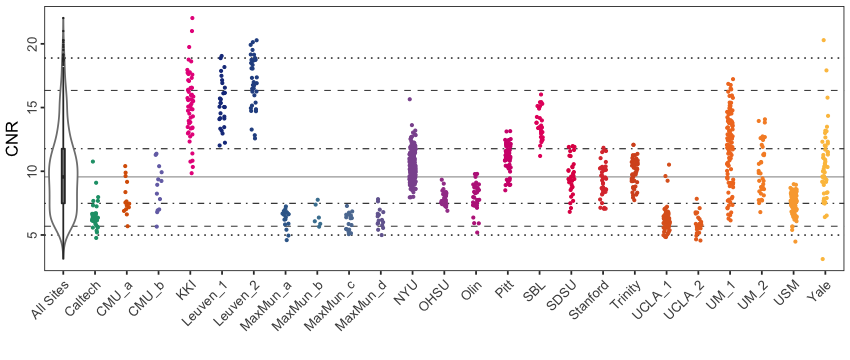

Plotting measure value - EFC 
...removing 0 points with NA values
...removed 8 outlier points
...plotting
...saving to abid_anat_spat_EFC.pdf 


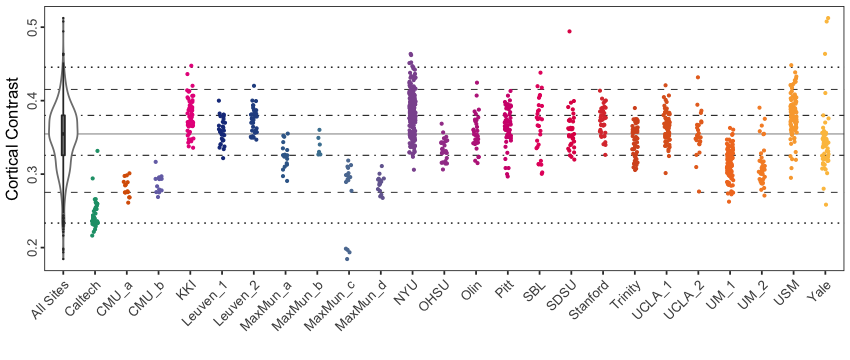

Plotting measure value - FBER 
...removing 0 points with NA values
...removed 2 outlier points
...plotting
...saving to abid_anat_spat_FBER.pdf 


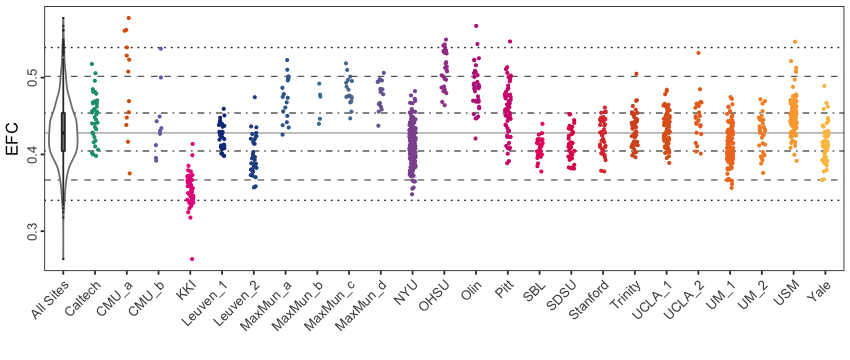

Plotting measure value - Smoothness (FWHM) 
...removing 0 points with NA values
...removed 0 outlier points
...plotting
...saving to abid_anat_spat_FWHM.pdf 


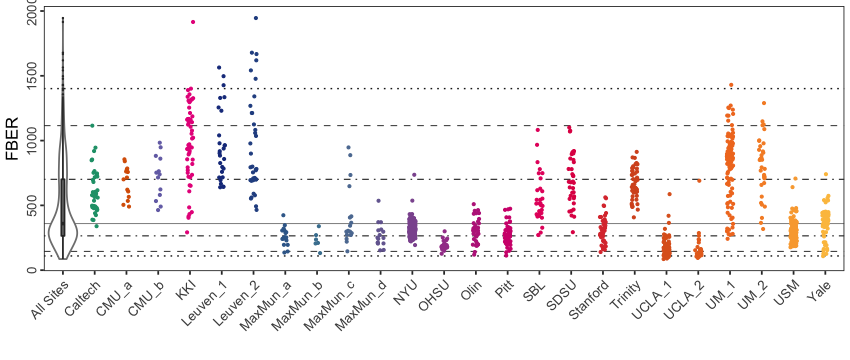

Plotting measure value - Fraction of Artifact Voxels 
...removing 0 points with NA values
...removed 7 outlier points
...plotting
...saving to abid_anat_spat_Qi1.pdf 


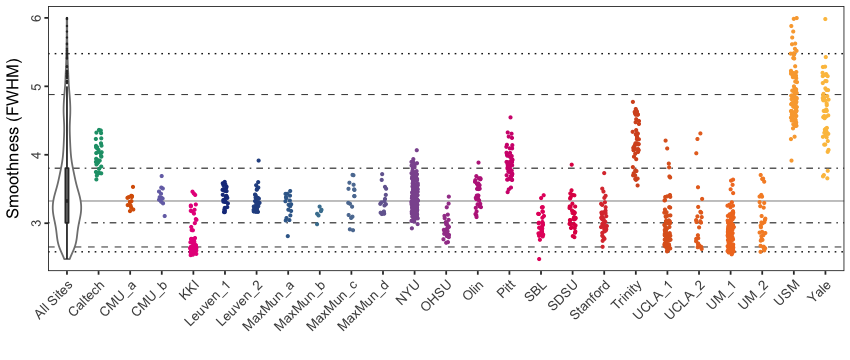

Plotting measure value - SNR 
...removing 0 points with NA values
...removed 0 outlier points
...plotting
...saving to abid_anat_spat_SNR.pdf 


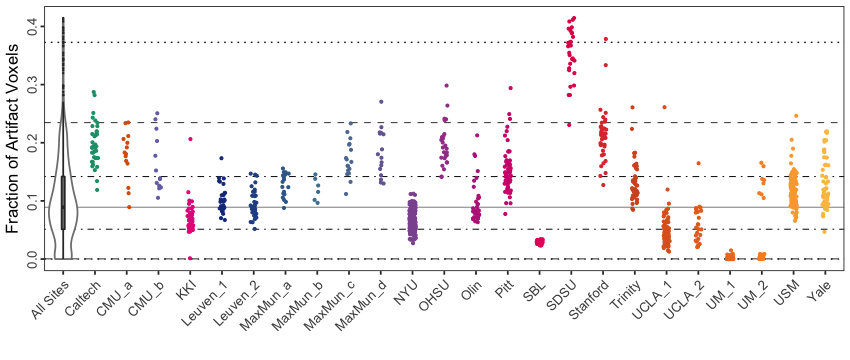

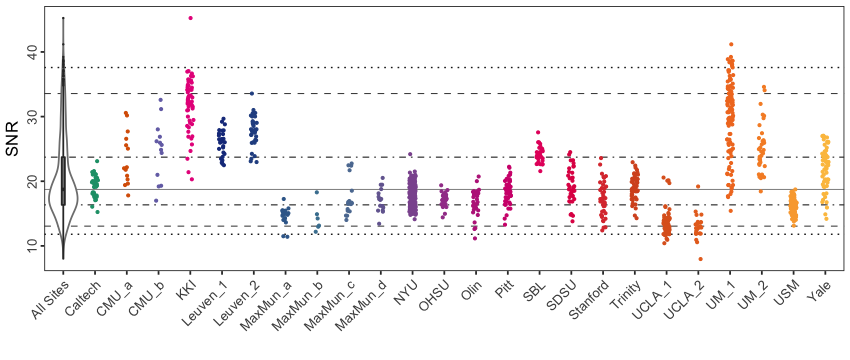

In [237]:
options(repr.plot.width=180.0/25.4, repr.plot.height=3)
for (measure in unique(abide_anat_spat_df$Measure)){
    sdf <- abide_anat_spat_df %>% filter(Measure == measure)
    plot_measure(sdf,"value",label_strings[[measure]],site.col="Site",plot=TRUE,
                 outfile=sprintf("abid_anat_spat_%s.pdf",measure), rm.outlier=TRUE) 
}

In [238]:
qc_qa_plots(abide_anat_spat_df,'qc_anat',label_strings,'abide_anat_qc.pdf',(180.0/25.4),2.5,7,1)

[1] "CNR CNR **** pval 1.760059e-11"
[1] "Cortical.Contrast Cortical Contrast **** pval 6.351518e-08"
[1] "EFC EFC ** pval 3.229117e-03"
[1] "FBER FBER ns pval 1.069308e-01"
[1] "FWHM Smoothness (FWHM) ns pval 2.532919e-01"
[1] "Qi1 Fraction of Artifact Voxels **** pval 7.913133e-15"
[1] "SNR SNR ** pval 7.035576e-03"


pdf 
  2

# ABIDE Functional Spatial QAP measures

### Read in the QAP measures, reduce to only the columns of interest, format for later processing, and plot

In [239]:
abide_func_spat_df<-read.csv("2016_05_ABIDE_functional_spatial.csv")
abide_func_spat_df=merge(abide_func_spat_df, pheno_df[c('Participant','qc_func')], by='Participant')

id.vars=c('Participant','Site','Session','Series','qc_func')
measure.vars=c('EFC','FBER','FWHM','Ghost_y','SNR')

abide_func_spat_df<-abide_func_spat_df[c(id.vars,measure.vars)]

abide_func_spat_df=melt(abide_func_spat_df,
                   id.vars=id.vars,
                   measure.vars=measure.vars,
                   variable.name="Measure")

abide_func_temp_df<-read.csv("2016_05_ABIDE_qap_functional_temporal.csv")
abide_func_temp_df=merge(abide_func_temp_df, pheno_df[c('Participant','qc_func')], by='Participant') 

measure.vars=c('Fraction.of.Outliers..Mean.','GCOR','Quality..Mean.','RMSD..Mean.','Std..DVARS..Mean.')

abide_func_temp_df<-abide_func_temp_df[c(id.vars,measure.vars)]

abide_func_temp_df=melt(abide_func_temp_df,
                   id.vars=id.vars,
                   measure.vars=measure.vars,
                   variable.name="Measure")

abide_func_df = rbind(abide_func_spat_df, abide_func_temp_df)


# remove outliers
abide_func_df <- abide_func_df %>% drop_na()
head(abide_func_df)

print(unique(abide_func_df$Measure))
# plots
label_strings=list(EFC='EFC',
                   FBER='FBER',
                   FWHM='Smoothness (FWHM)',
                   Ghost_y='GSR',
                   SNR='SNR',
                   Fraction.of.Outliers..Mean.='Mean Fraction of Outliers',
                   GCOR='GCOR',
                   Quality..Mean.='Mean AFNI Quality Index',
                   RMSD..Mean.='Mean RMSD',
                   Std..DVARS..Mean.='Mean Std. DVARS')

  
qc_qa_plots(abide_func_df,'qc_func',label_strings,'abide_func_qc.pdf',(180.0*5.0/7.0)/25.4,5,5,2)

,Participant,Site,Session,Series,qc_func,Measure,value
1,50002,Pitt,session_1,rest_1,Fail,EFC,0.6130960682
2,50003,Pitt,session_1,rest_1,OK,EFC,0.5783131207
3,50004,Pitt,session_1,rest_1,OK,EFC,0.579523984
4,50005,Pitt,session_1,rest_1,Fail,EFC,0.5561542138
5,50006,Pitt,session_1,rest_1,OK,EFC,0.5628428785
6,50007,Pitt,session_1,rest_1,OK,EFC,0.6081622278


 [1] EFC                         FBER                       
 [3] FWHM                        Ghost_y                    
 [5] SNR                         Fraction.of.Outliers..Mean.
 [7] GCOR                        Quality..Mean.             
 [9] RMSD..Mean.                 Std..DVARS..Mean.          
10 Levels: EFC FBER FWHM Ghost_y SNR Fraction.of.Outliers..Mean. ... Std..DVARS..Mean.
[1] "EFC EFC ** pval 1.125368e-03"
[1] "FBER FBER ns pval 1.949145e-01"
[1] "FWHM Smoothness (FWHM) *** pval 1.281002e-04"
[1] "Ghost_y GSR **** pval 6.209552e-10"
[1] "SNR SNR **** pval 2.666120e-05"
[1] "Fraction.of.Outliers..Mean. Mean Fraction of Outliers ** pval 1.601341e-03"
[1] "GCOR GCOR **** pval 2.622940e-14"
[1] "Quality..Mean. Mean AFNI Quality Index **** pval 2.394603e-07"
[1] "RMSD..Mean. Mean RMSD **** pval 2.213172e-08"
[1] "Std..DVARS..Mean. Mean Std. DVARS ns pval 6.636269e-02"


pdf 
  2

Plotting measure value - EFC 
...removing 0 points with NA values
...removed 0 outlier points
...plotting
...saving to abid_func_EFC.pdf 
Plotting measure value - FBER 
...removing 0 points with NA values
...removed 0 outlier points
...plotting
...saving to abid_func_FBER.pdf 


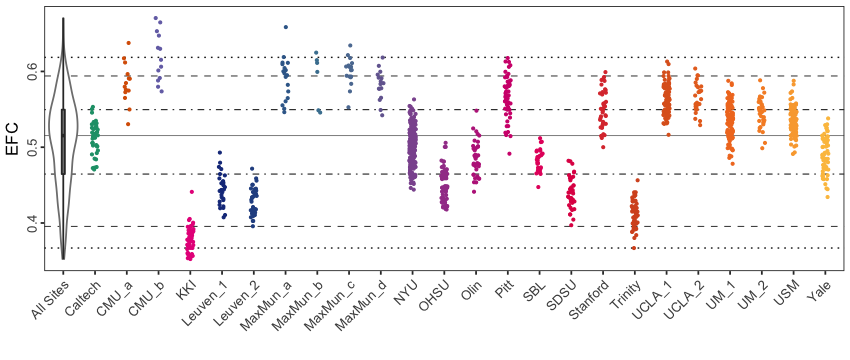

Plotting measure value - Smoothness (FWHM) 
...removing 0 points with NA values
...removed 1 outlier points
...plotting
...saving to abid_func_FWHM.pdf 


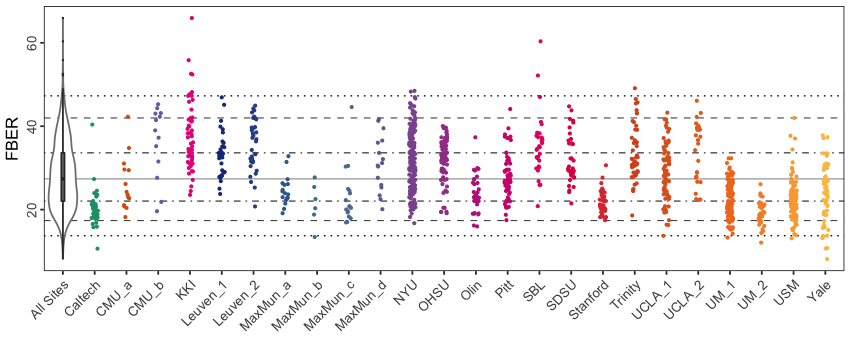

Plotting measure value - GSR 
...removing 0 points with NA values
...removed 0 outlier points
...plotting
...saving to abid_func_Ghost_y.pdf 


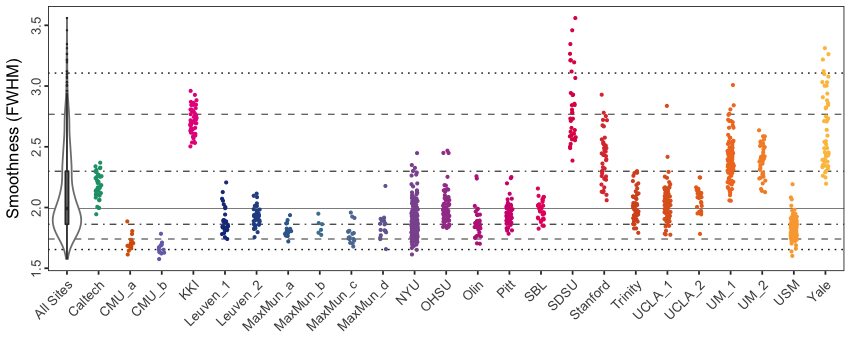

Plotting measure value - SNR 
...removing 0 points with NA values
...removed 0 outlier points
...plotting
...saving to abid_func_SNR.pdf 


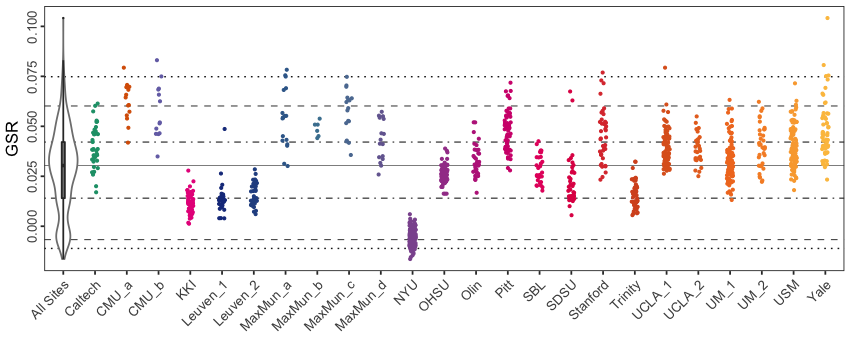

Plotting measure value - Mean Fraction of Outliers 
...removing 0 points with NA values
...removed 51 outlier points
...plotting
...saving to abid_func_FractionofOutliersMean.pdf 


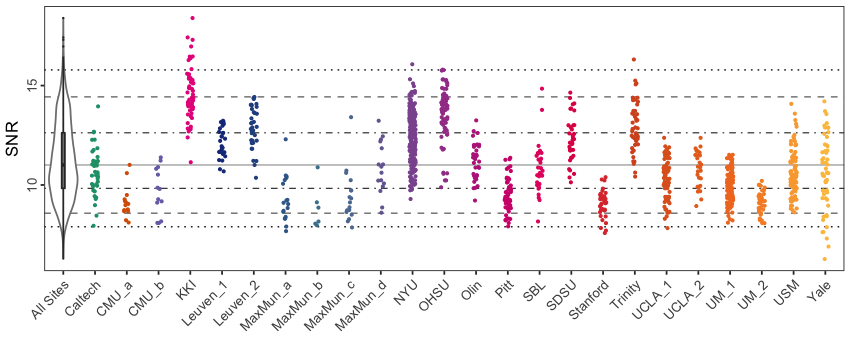

Plotting measure value - GCOR 
...removing 0 points with NA values
...removed 134 outlier points
...plotting
...saving to abid_func_GCOR.pdf 


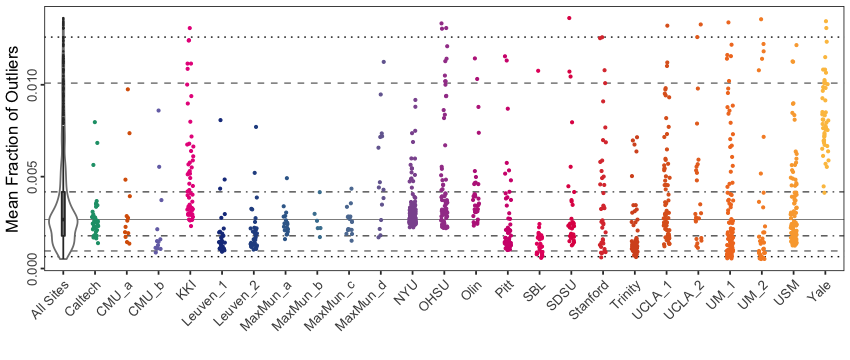

Plotting measure value - Mean AFNI Quality Index 
...removing 0 points with NA values
...removed 2 outlier points
...plotting
...saving to abid_func_QualityMean.pdf 


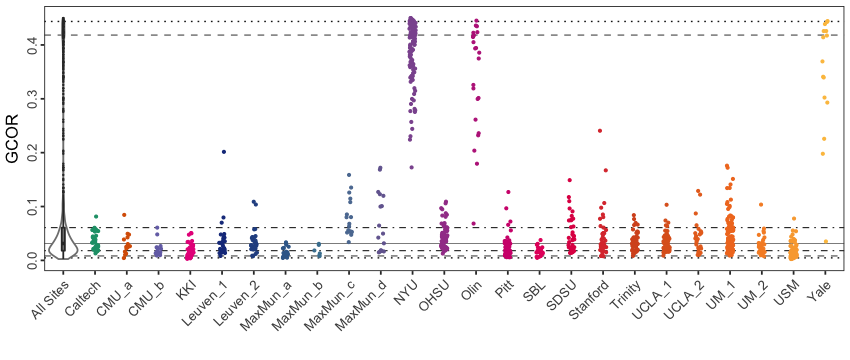

Plotting measure value - Mean RMSD 
...removing 0 points with NA values
...removed 56 outlier points
...plotting
...saving to abid_func_RMSDMean.pdf 


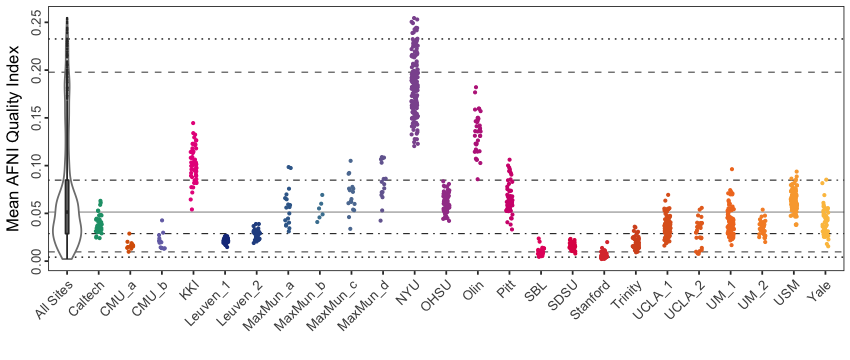

Plotting measure value - Mean Std. DVARS 
...removing 0 points with NA values
...removed 1 outlier points
...plotting
...saving to abid_func_StdDVARSMean.pdf 


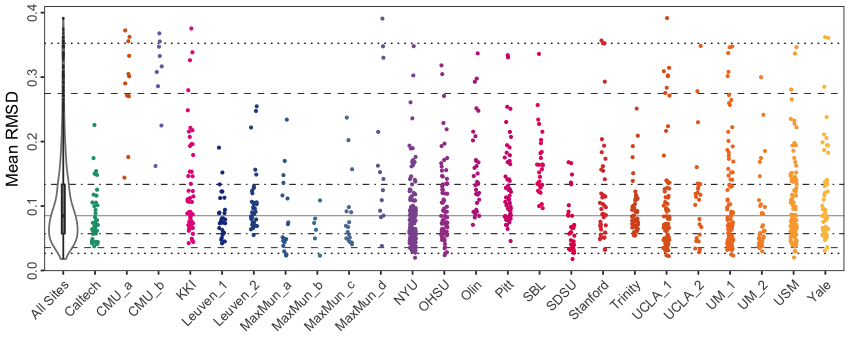

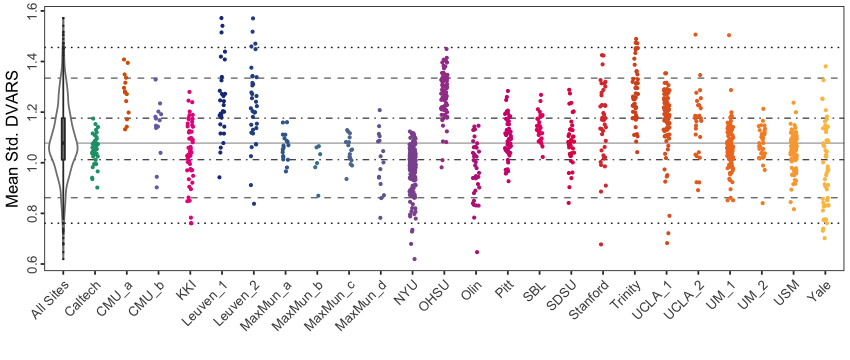

In [250]:
options(repr.plot.width=180.0/25.4, repr.plot.height=3)
for (measure in unique(abide_func_df$Measure)){
    sdf <- abide_func_df %>% filter(Measure == measure)
    plot_measure(sdf,"value",label_strings[[measure]],site.col="Site",plot=TRUE,
                 outfile=sprintf("abid_func_%s.pdf",gsub(".", "", measure,fixed=TRUE)), rm.outlier=TRUE) 
} 

In [249]:
gsub(".","",measure,fixed=TRUE)

[1] "StdDVARSMean"

In [246]:
?gsub

In [1]:
abide_func_df$qc_func

ERROR: Error in eval(expr, envir, enclos): object 'abide_func_df' not found
